In [ ]:
import os
import re
import unicodedata
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import textstat
from textblob import TextBlob
from textblob_nl import PatternAnalyzer
from tqdm.notebook import tqdm
import requests
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


With lag

In [4]:

# Laad de dataset
df = pd.read_csv(r"E:\Nieuw dataset\df_joined_datasets_time_index.csv")

# Functie om lag toe te voegen
def add_lag_feature(df, column='Totaal_verkochte_wegvoertuigen', lag=1):
    df[f'{column}_lag{lag}'] = df[column].shift(lag)
    return df

# Voeg lag 1 toe
df_lagged = add_lag_feature(df, column='Totaal_verkochte_wegvoertuigen', lag=1)

# Verwijder rijen met NaN (eerste rij door lag)
df_lagged = df_lagged.dropna().reset_index(drop=True)

# Opslaan als nieuwe CSV
output_path = r"E:\Nieuw dataset\lag/joined_datasets_with_lag1.csv"
df_lagged.to_csv(output_path, index=False)



#### Data splitsen

In [6]:

# 1. Laad gelagged dataset
df_lagged = pd.read_csv(r"E:\Nieuw dataset\lag\joined_datasets_with_lag1.csv")

# 2. Stel hoeveel maanden voor validatie en test
n_val = 12   # voorlaatste jaar
n_test = 12  # laatste jaar

# 3. Bereken splits
n_total = len(df_lagged)
n_train = n_total - n_val - n_test

# 4. Maak splits
df_train = df_lagged.iloc[:n_train].copy()
df_val   = df_lagged.iloc[n_train:n_train + n_val].copy()
df_test  = df_lagged.iloc[n_train + n_val:].copy()

# 5. Opslaan als aparte CSV-bestanden met "lag" toevoeging
output_dir = r"E:\Nieuw dataset\lag"
os.makedirs(output_dir, exist_ok=True)

df_train.to_csv(os.path.join(output_dir, "joined_dataset_train_lag.csv"), index=False)
df_val.to_csv(os.path.join(output_dir, "joined_dataset_val_lag.csv"), index=False)
df_test.to_csv(os.path.join(output_dir, "joined_dataset_test_lag.csv"), index=False)

# 6. Check
print(f"Train: {df_train.shape}, Val: {df_val.shape}, Test: {df_test.shape}")
print("Train laatste maand:", df_train['Periode'].iloc[-1])
print("Val eerste maand:", df_val['Periode'].iloc[0])
print("Test eerste maand:", df_test['Periode'].iloc[0])

Train: (96, 18), Val: (12, 18), Test: (12, 18)
Train laatste maand: 2023-01-01
Val eerste maand: 2023-02-01
Test eerste maand: 2024-02-01


In [8]:
display(df_train.head())

,Periode,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,BenzineEuro95_1_first,BenzineEuro95_1_last,BenzineEuro95_1_min,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean,average_sentiment_per_month,time_index,Totaal_verkochte_wegvoertuigen,Totaal_verkochte_wegvoertuigen_lag1
0,2015-02-01,10.0,30.0,-4.0,1.461,1.557,1.461,1.557,1.520143,1.192,1.291,1.192,1.291,1.253964,0.106743,1,926.0,1202.0
1,2015-03-01,10.0,30.0,-4.0,1.559,1.601,1.559,1.603,1.586161,1.291,1.277,1.276,1.294,1.286613,0.081516,2,1615.0,926.0
2,2015-04-01,10.0,30.0,-4.0,1.599,1.646,1.592,1.647,1.614467,1.275,1.312,1.261,1.312,1.283367,0.057695,3,1362.0,1615.0
3,2015-05-01,10.2,29.6,-3.2,1.645,1.639,1.634,1.648,1.640806,1.310,1.306,1.306,1.313,1.309710,0.109200,4,1332.0,1362.0
4,2015-06-01,10.4,29.2,-2.4,1.638,1.653,1.638,1.668,1.654933,1.304,1.295,1.293,1.310,1.301400,0.083417,5,1669.0,1332.0


#### Corrolatie 

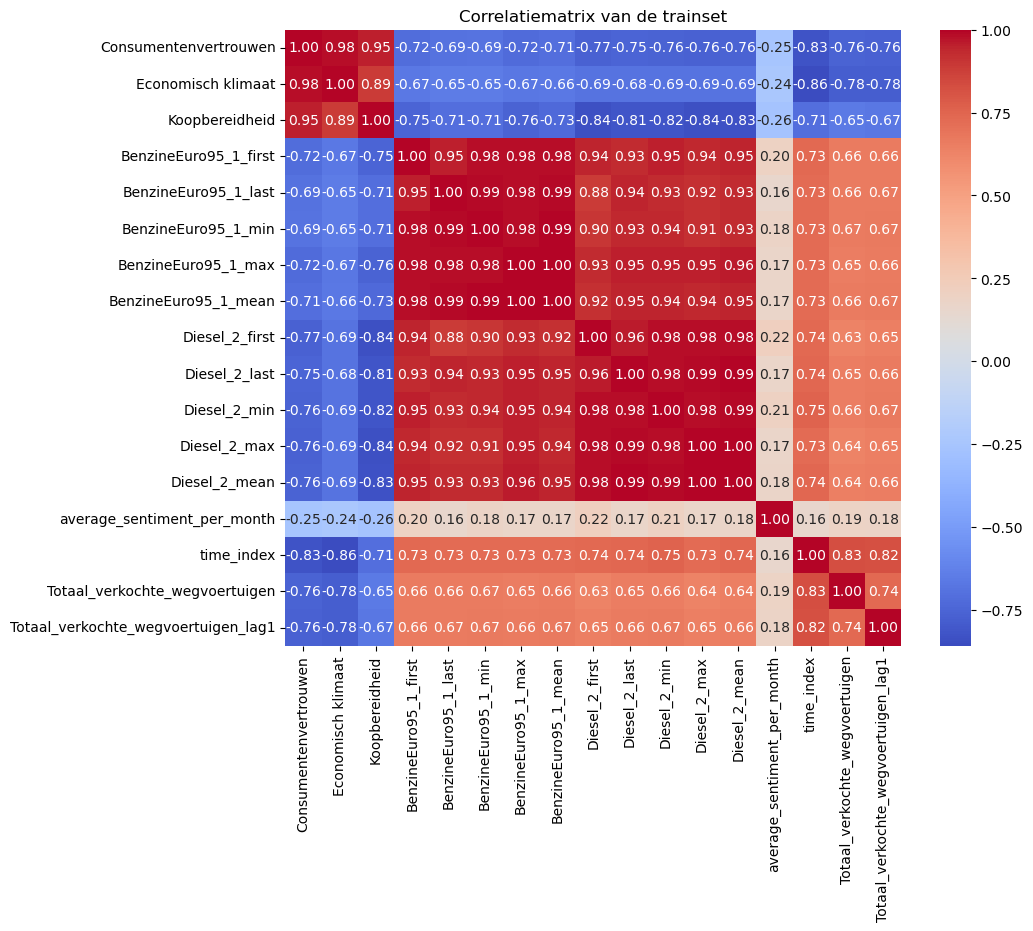

In [ ]:
# Correlatiematrix berekenen op de trainset
correlation_matrix_train = df_train.drop(columns=['Periode']).corr()

# Heatmap plotten
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_train, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlatiematrix van de trainset")
plt.show()

#### ingezoomd corrolatie 

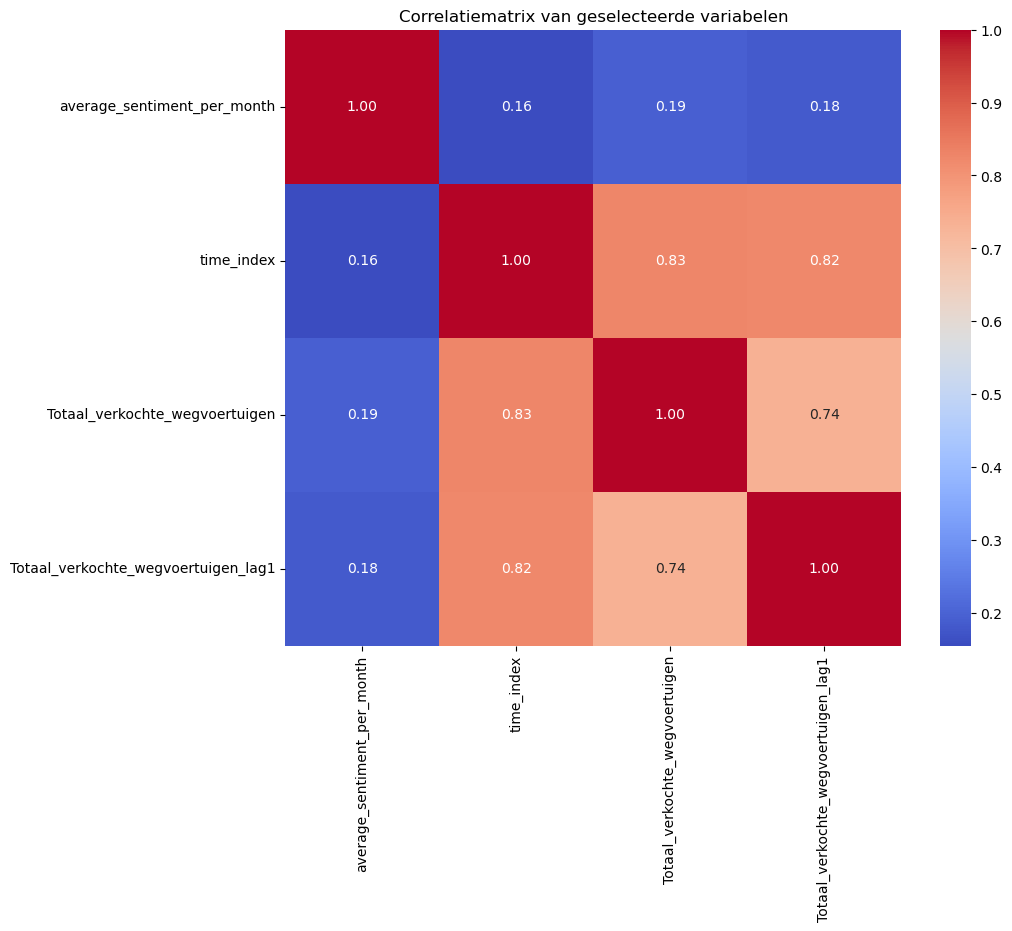

In [10]:
# Select only the required columns
selected_columns = ['average_sentiment_per_month', 'time_index', 
                   'Totaal_verkochte_wegvoertuigen', 'Totaal_verkochte_wegvoertuigen_lag1']

# Calculate correlation matrix for selected columns
correlation_matrix_selected = df_train[selected_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_selected, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlatiematrix van geselecteerde variabelen")
plt.show()

#### Diverse scatterplots

In [ ]:


def visualiseer_train_set(df_train):



    # Scatterplot instellingen (x, y, kleur, titel, xlabel)
    scatterplots = [
        ('Consumentenvertrouwen', 'Totaal_verkochte_wegvoertuigen', 'blue', 'Consumentenvertrouwen vs Autoverkoop'),
        ('average_sentiment_per_month', 'Totaal_verkochte_wegvoertuigen', 'green', 'Sentimentanalyse vs Autoverkoop'),
        ('time_index', 'Totaal_verkochte_wegvoertuigen', 'blue', 'Tijdindex vs Autoverkoop'),
        ('Totaal_verkochte_wegvoertuigen_lag1', 'Totaal_verkochte_wegvoertuigen', 'blue', 'Lag1 Autoverkoop vs Autoverkoop')
    ]

    for x, y, color, title in scatterplots:
        plt.figure(figsize=(8, 6))
        plt.scatter(df_train[x], df_train[y], alpha=0.7, color=color)
        plt.title(f'{title} (Train Set)')
        plt.xlabel(x)
        plt.ylabel(y)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Lijngrafiek: Autoverkoop per maand
    plt.figure(figsize=(12, 6))
    plt.plot(df_train['Periode'], df_train['Totaal_verkochte_wegvoertuigen'], marker='o', color='red', label='Autoverkoop')
    plt.title('Autoverkoop per maand (Train Set)')
    plt.xlabel('Periode')
    plt.ylabel('Aantal verkochte voertuigen')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Lijngrafiek: Consumentenvertrouwen en indicatoren
    plt.figure(figsize=(14, 6))
    plt.plot(df_train['Periode'], df_train['Consumentenvertrouwen'], label='Consumentenvertrouwen', marker='x', color='blue')
    plt.plot(df_train['Periode'], df_train['Economisch klimaat'], label='Economisch klimaat', linestyle='--', color='green')
    plt.plot(df_train['Periode'], df_train['Koopbereidheid'], label='Koopbereidheid', linestyle='--', color='orange')

    plt.axhspan(0, df_train[['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid']].max().max(), color='lightgreen', alpha=0.2, label='Positief vertrouwen')
    plt.axhspan(df_train[['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid']].min().min(), 0, color='lightcoral', alpha=0.2, label='Negatief vertrouwen')

    plt.title('Consumentenvertrouwen en deelindicatoren (Train Set)')
    plt.xlabel('Periode')
    plt.ylabel('Waarde index (schaal -100 tot 100)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


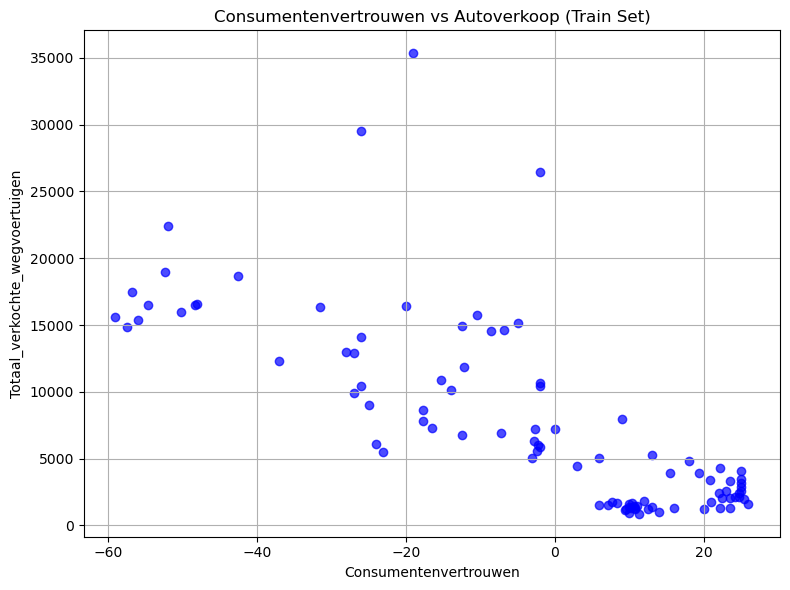

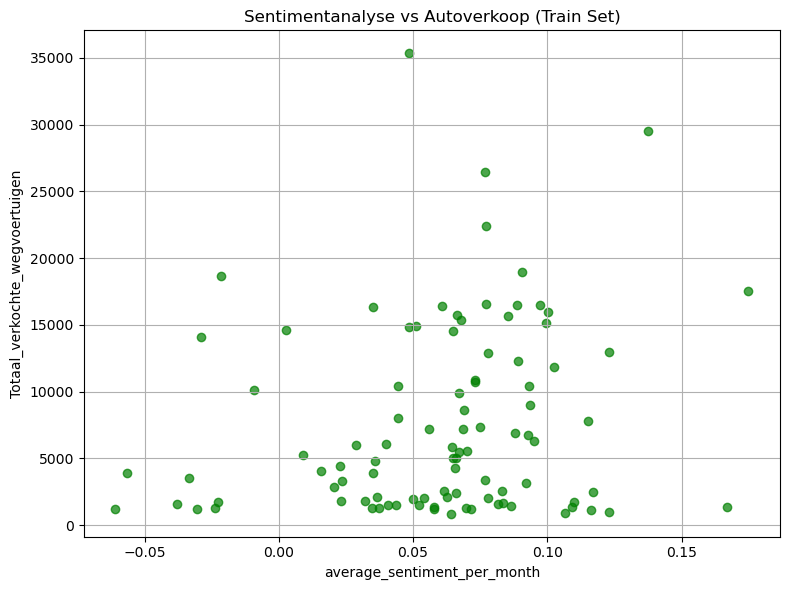

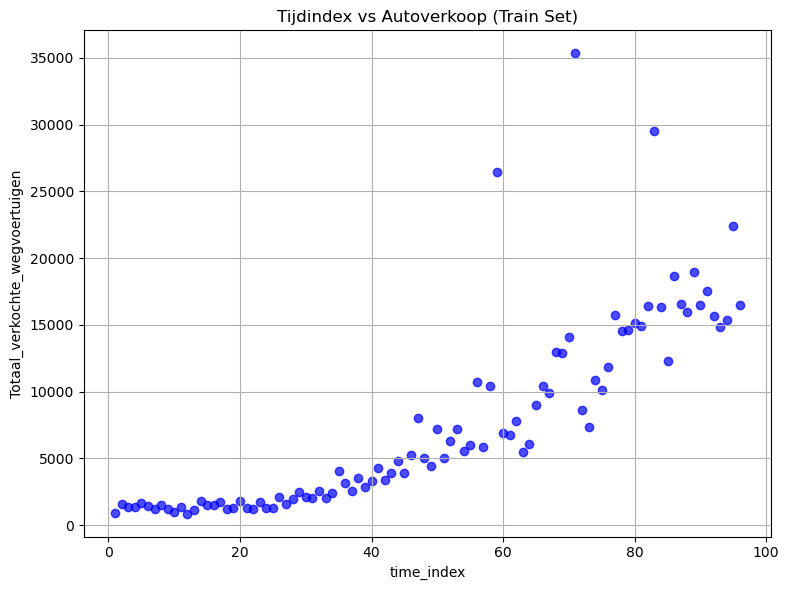

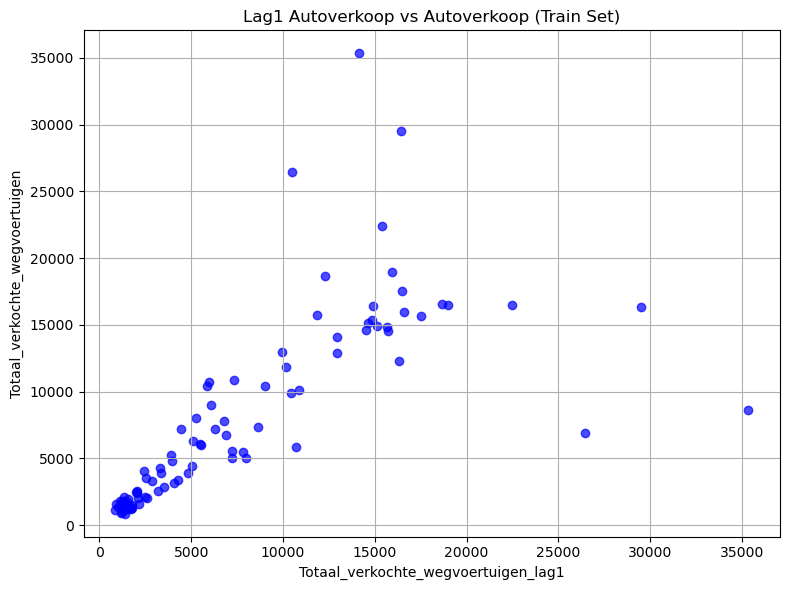

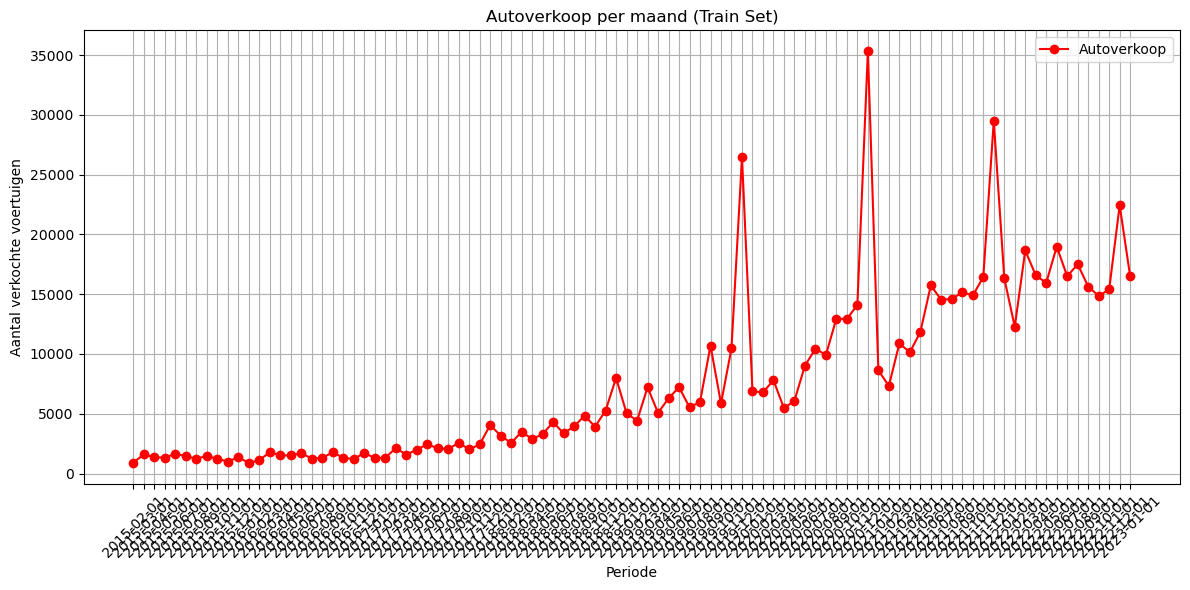

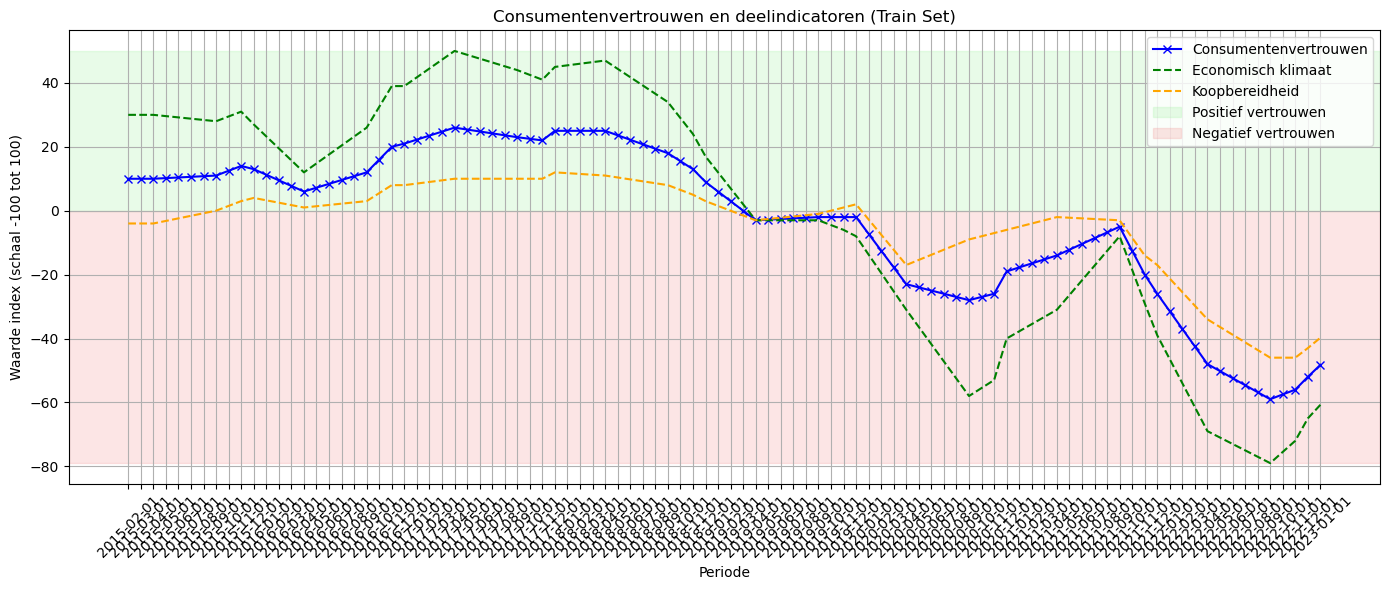

In [16]:
visualiseer_train_set(df_train)


### XGBoost time series forecast met walk-forward validatie

In [ ]:

def xgboost_forecast(trainX, trainy, valx):
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(trainX, trainy)
    return model.predict(np.array([valx]))[0]

def walk_forward_prediction(df_train, df_val, target_col='Totaal_verkochte_wegvoertuigen'):
    # Alleen numerieke features gebruiken (behalve target)
    feature_cols = df_train.select_dtypes(include=[np.number]).columns.drop(target_col)
    
    trainX = df_train[feature_cols].values
    trainy = df_train[target_col].values
    valX = df_val[feature_cols].values
    valy = df_val[target_col].values

    predictions = []
    monthly_mae = []

    for i in range(len(valX)):
        valx = valX[i]
        yhat = xgboost_forecast(trainX, trainy, valx)
        predictions.append(yhat)

        # MAE voor deze maand
        month_mae = mean_absolute_error([valy[i]], [yhat])
        monthly_mae.append(month_mae)
        print(f"Maand {df_val['Periode'].iloc[i]}: Voorspeld (valX)={yhat:.2f}, Werkelijk={valy[i]:.2f}, MAE={month_mae:.2f}")

        # Walk-forward: voeg echte waarde toe aan trainset
        new_row = df_val.iloc[i:i+1].copy()
        new_row[target_col] = valy[i]
        df_train = pd.concat([df_train, new_row], ignore_index=True)
        trainX = df_train[feature_cols].values
        trainy = df_train[target_col].values

    overall_mae = mean_absolute_error(valy, predictions)
    print(f"\n Overall MAE op validatieset: {overall_mae:.2f}")

    # Visualisatie
    plt.figure(figsize=(12, 6))
    plt.plot(df_val['Periode'], valy, label='Werkelijk', marker='o', color='blue')
    plt.plot(df_val['Periode'], predictions, label='Voorspeld (valX)', marker='x', color='red')
    plt.title('Werkelijk vs Voorspeld (valX)')
    plt.xlabel('Periode')
    plt.ylabel('Aantal verkochte voertuigen')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return predictions, overall_mae

    


Maand 2023-02-01: Voorspeld (valX)=17597.59, Werkelijk=16593.00, MAE=1004.59
Maand 2023-03-01: Voorspeld (valX)=16520.93, Werkelijk=24311.00, MAE=7790.07
Maand 2023-04-01: Voorspeld (valX)=18758.22, Werkelijk=18281.00, MAE=477.22
Maand 2023-05-01: Voorspeld (valX)=19186.00, Werkelijk=22305.00, MAE=3119.00
Maand 2023-06-01: Voorspeld (valX)=19538.30, Werkelijk=27262.00, MAE=7723.70
Maand 2023-07-01: Voorspeld (valX)=17174.88, Werkelijk=27851.00, MAE=10676.12
Maand 2023-08-01: Voorspeld (valX)=16230.96, Werkelijk=22109.00, MAE=5878.04
Maand 2023-09-01: Voorspeld (valX)=18995.12, Werkelijk=26040.00, MAE=7044.88
Maand 2023-10-01: Voorspeld (valX)=19259.90, Werkelijk=23240.00, MAE=3980.10
Maand 2023-11-01: Voorspeld (valX)=19351.79, Werkelijk=23676.00, MAE=4324.21
Maand 2023-12-01: Voorspeld (valX)=27011.77, Werkelijk=23490.00, MAE=3521.77
Maand 2024-01-01: Voorspeld (valX)=24741.20, Werkelijk=24325.00, MAE=416.20

📉 Overall MAE op validatieset: 4662.99


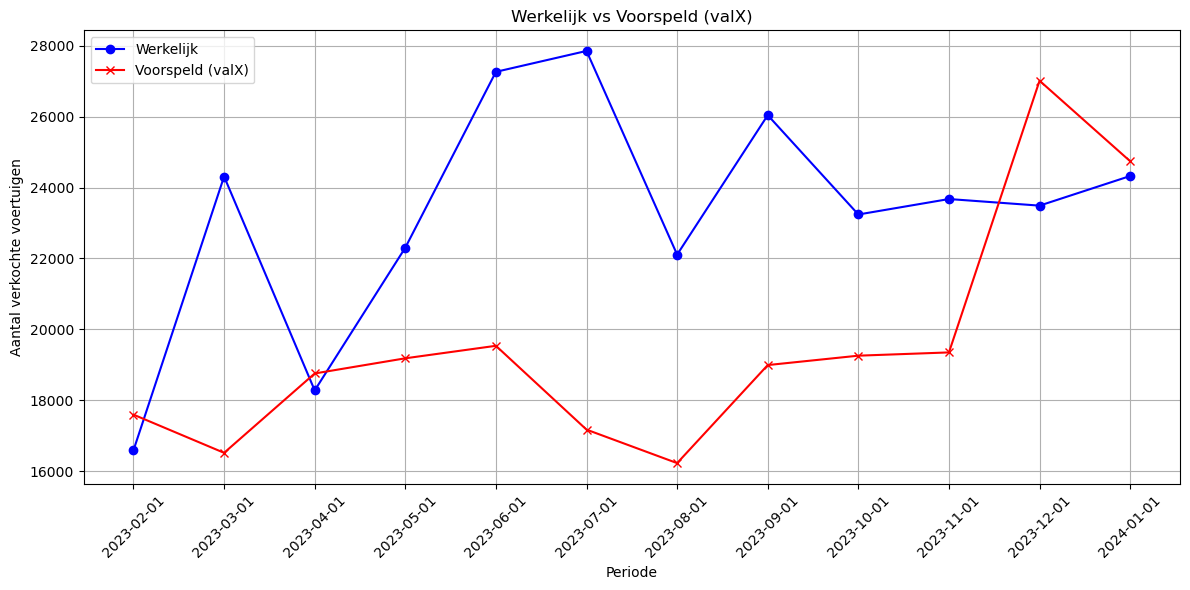

In [25]:
predictions, overall_mae = walk_forward_prediction(df_train, df_val, target_col='Totaal_verkochte_wegvoertuigen')


### LOFO


LOFO - Zonder: Nieuws
Index(['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid',
       'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
       'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first',
       'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean',
       'time_index', 'Totaal_verkochte_wegvoertuigen_lag1'],
      dtype='object')
Gebruikte features (15): ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean', 'time_index', 'Totaal_verkochte_wegvoertuigen_lag1']
MAE: 6754.64, Gemiddelde foutmarge: 28.00%

LOFO - Zonder: Brandstofprijzen
Index(['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid',
       'average_sentiment_per_month', 'time_index',
       'Totaal_verkochte_wegvoertuigen_lag1'],
    

,weggelaten_featuregroep,aantal_features_gebruikt,mae,gem_foutmarge_%
0,Nieuws,15,6754.642578,28.003590
4,Voorgaande_verkoop_Lag1,15,6851.630127,28.216901
3,Tijd,15,7061.696289,29.037080
2,Economisch,13,7177.266764,29.524074
1,Brandstofprijzen,6,7411.974284,30.642963


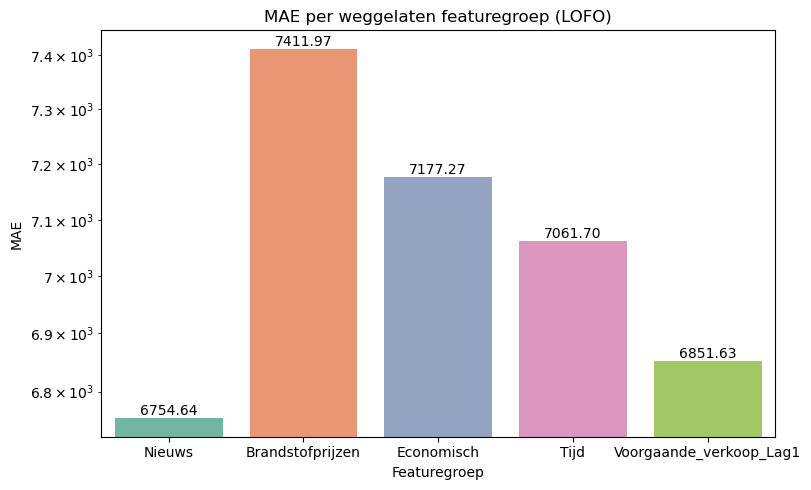

In [41]:
# Combineer de datasets om df_joined te maken
df_joined = pd.concat([df_train, df_val], ignore_index=True)

# Groepeer je features in betekenisvolle groepen voor LOFO
feature_groups = {
    'Nieuws': [col for col in df_joined.columns if 'sentiment' in col.lower()],  
    'Brandstofprijzen': [col for col in df_joined.columns if 'benzine' in col.lower() or 'diesel' in col.lower()],
    'Economisch': ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid'],
    'Tijd':['time_index'],
    'Voorgaande_verkoop_Lag1': ['Totaal_verkochte_wegvoertuigen_lag1'],
}

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

results = []

for group_name, excluded_cols in feature_groups.items():
    print(f"\nLOFO - Zonder: {group_name}")

    # Verwijder kolommen uit train en val
    # Ensure the same columns are used for both train and validation datasets
    
    #common_columns = df_train.drop(columns=excluded_cols + ['Periode']).columns
    common_columns = df_train.drop(columns=excluded_cols + ['Periode', 'Totaal_verkochte_wegvoertuigen']).columns
    train_lofo = df_train[common_columns]
    val_lofo = df_val[common_columns]
    print(train_lofo.columns)

    included_cols = train_lofo.columns.tolist()
    print(f"Gebruikte features ({len(included_cols)}): {included_cols}")

    # Zet om naar numpy arrays
    trainX, trainy = train_lofo.values, df_train['Totaal_verkochte_wegvoertuigen'].values
    valX, valy     = val_lofo.values, df_val['Totaal_verkochte_wegvoertuigen'].values

    # Train en voorspel
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(trainX, trainy)
    predictions = model.predict(valX)

    # Evaluatie
    mae = mean_absolute_error(valy, predictions)
    fouten = np.abs(valy - predictions)
    foutmarges = (fouten / valy) * 100
    avg_foutmarge = foutmarges.mean()

    print(f"MAE: {mae:.2f}, Gemiddelde foutmarge: {avg_foutmarge:.2f}%")

    results.append({
        'weggelaten_featuregroep': group_name,
        'aantal_features_gebruikt': len(included_cols),
        'mae': mae,
        'gem_foutmarge_%': avg_foutmarge
    })

# Optioneel: omzetting naar DataFrame
df_results = pd.DataFrame(results).sort_values(by='mae')



# DataFrame van resultaten
df_results = pd.DataFrame(results)
display(df_results.sort_values(by='mae'))

# Voeg 'Nieuws' toe aan de barplot
plt.figure(figsize=(8, 5))
barplot = sns.barplot(data=df_results, x='weggelaten_featuregroep', y='mae', hue='weggelaten_featuregroep', dodge=False, palette='Set2', legend=False)
plt.title("MAE per weggelaten featuregroep (LOFO)")
plt.ylabel("MAE")
plt.xlabel("Featuregroep")
plt.tight_layout()
plt.yscale("log")

# Add MAE values on top of the bars
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=10)

plt.show()




De output laat de resultaten zien van het XGBoost-model voor tijdreeksvoorspelling van autoverkopen. Belangrijke punten:

- **Correlatiematrix**: Geeft inzicht in de samenhang tussen sentiment, tijdindex, verkoopaantallen en lag.
- **Walk-forward validatie**: Het model voorspelt per maand de autoverkopen op de validatieset. De gemiddelde absolute fout (MAE) op de validatieset is 4663.
- **LOFO-analyse**: Door telkens één featuregroep weg te laten, wordt duidelijk welke groepen het meest bijdragen aan de nauwkeurigheid. Het weglaten van 'Voorgaande_verkoop' leidt tot de hoogste MAE (6852), wat aangeeft dat deze groep het belangrijkst is.
- **Feature importance**: De individuele bijdrage van elke feature aan de modelprestatie is berekend. 'Totaal_verkochte_wegvoertuigen_lag1' heeft de grootste negatieve ΔMAE, wat betekent dat het verwijderen van deze feature de MAE sterk verhoogt.

Kortom: De lag-feature (vorige maand verkoop) is het meest bepalend voor de voorspellingen, gevolgd door tijdindex en sentiment.